In [1]:
wdir='./' ## working dir
gColab=True  ## set this to False if running locally
if(gColab):
    ## Mount google drive to the machine running this nb
    from google.colab import drive
    drive.mount('/content/drive')
    ## must also specify the absolute path to the working dir
    wdir='/content/drive/MyDrive/ColabNtbs/ysNN_PolyN/batch_104_fit/'

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

gseed=99
if(1):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.random.set_seed(gseed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

## set off randomness
np.random.seed(gseed)
random.seed(gseed)
os.environ['PYTHONHASHSEED']=str(gseed)
tf.random.set_seed(gseed)

In [3]:
degree=4
nMonoms=int((int(degree/2+1))**2)
vPoints,vKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4.txt','r')
maxShear=9.0e+16  ###  NN-model without convexity constraints  (DO NOT exclude data)
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        ################# Exclude points with too small pure shear
        line=[float(x) for x in line]  #;print(line[nMonoms-1])
        if(abs(line[nMonoms-1])<maxShear):
            vPoints.append(line[0:nMonoms])
            vKG.append(line[-1])
        #vPoints.append(line[0:nMonoms])
        #vKG.append(line[-1])
ff.close()
vPoints=np.array(vPoints)
nPoints=vPoints.shape[0]
vKG=np.array(vKG).reshape((nPoints,1))
print(vPoints.shape,nPoints)

## investigate spread
cntp=np.sum(vPoints,axis=0)/nPoints;
for kk in range(cntp.shape[0]):
    print('center point[{kk}] = ',cntp[kk])
## compare to Mises
print('cntp = ',cntp)
vMises=np.array([1, -2, 3, -2, 1, 6, -6, 6, 9],dtype=np.double); print('von Mises = ',vMises)
dxMax=np.zeros(nMonoms)
for kk in range(nMonoms):
    dxMax[kk]=np.max(np.abs(vPoints[:,kk]-cntp[kk]))
    print(kk,': dxMax = ',dxMax[kk])

### spread is large --->>> normalize the data
### also, exclude the first component: this is '1' for all
vPoints=vPoints[:,1:]
dxMax=dxMax[1:]
cntp=cntp[1:]
nMonoms-=1
for kk in range(nMonoms):
    vPoints[:,kk]=(vPoints[:,kk]-cntp[kk])/dxMax[kk]
#print(vPoints[0,:])
#print(vPoints.shape)
#nZeros=int(nPoints/2.0)
#vPoints=np.concatenate((vPoints,np.zeros((nZeros,8))),axis=0)

vTestPoints,vTestKG=[],[]
ff=open(wdir+'aCVXbdry_deg_4_test.txt','r')
for line in ff:
    line=line.strip()
    if(line):
        line=line.split(',')
        ################# Exclude points with too small pure shear
        line=[float(x) for x in line]
        #if(max([abs(x) for x in line[0:nMonoms]])<maxShear and(abs(line[-1])<10.0)):
        if(abs(line[nMonoms])<maxShear):
            vTestPoints.append(line[1:nMonoms+1])
            vTestKG.append(line[-1])
        #vTestPoints.append(line[1:nMonoms+1])
        #vTestKG.append(line[-1])
ff.close()
vTestPoints=np.array(vTestPoints)
nTestPoints=vTestPoints.shape[0]
vTestKG=np.array(vTestKG).reshape((nTestPoints,1))
for kk in range(nMonoms):
    vTestPoints[:,kk]=(vTestPoints[:,kk]-cntp[kk])/dxMax[kk]


nZeros=100
vPoints=np.concatenate((vPoints,vTestPoints,np.zeros((nZeros,nMonoms))),axis=0)
vKG=np.concatenate((vKG,vTestKG,np.zeros((nZeros,1))),axis=0)


### Scramble the data and generate targets
np.random.seed(gseed)
#pp=np.random.permutation(nPoints+nZeros)
pp=np.random.permutation(vPoints.shape[0])

#vtt=vPoints[pp[:]]
#vPoints[:]=v[pp[:]]
#vKG=
print('min and max of KG =',np.min(vKG),np.max(vKG))
#vTargets=np.exp(-vKG[pp[:]])
vTargets=(vKG[pp[:]]<0.0).astype(int)


## Targets
#vTargets=np.ones((nPoints,1))
#vTargets=np.concatenate((vTargets,np.zeros((nZeros,1))),axis=0)
print('number of data points = ',vTargets.shape[0])

(20000, 9) 20000
center point[{kk}] =  1.0
center point[{kk}] =  -1.6129362192236751
center point[{kk}] =  3.454157357252988
center point[{kk}] =  -1.7653572545874991
center point[{kk}] =  1.862396791843772
center point[{kk}] =  6.111839159843277
center point[{kk}] =  -5.921176129510384
center point[{kk}] =  6.1850318108821885
center point[{kk}] =  9.12879232596765
cntp =  [ 1.         -1.61293622  3.45415736 -1.76535725  1.86239679  6.11183916
 -5.92117613  6.18503181  9.12879233]
von Mises =  [ 1. -2.  3. -2.  1.  6. -6.  6.  9.]
0 : dxMax =  0.0
1 : dxMax =  8.420482078405513
2 : dxMax =  60.72447809357019
3 : dxMax =  100.28299963683395
4 : dxMax =  123.27000099311208
5 : dxMax =  78.44972776373547
6 : dxMax =  72.87225156911263
7 : dxMax =  125.62917310072585
8 : dxMax =  246.0112253395461
min and max of KG = -847610.3890454104 0.44803966576271037
number of data points =  287747


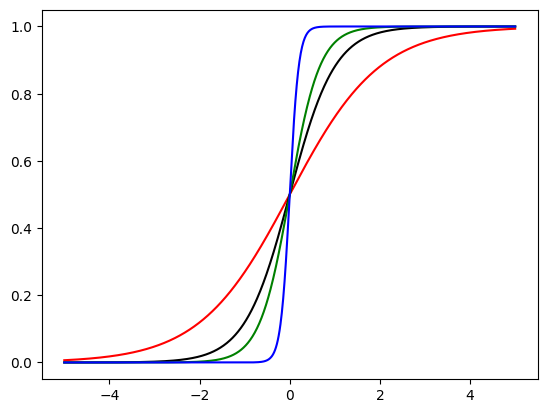

In [ ]:
vx=np.linspace(-5,5,1000)
sfg=plt.figure()
ax=sfg.add_subplot()
ax.plot(vx,1.0/(1.0+np.exp(-vx)),color='r')
ax.plot(vx,1.0/(1.0+np.exp(-2*vx)),color='k')
ax.plot(vx,1.0/(1.0+np.exp(-3*vx)),color='g')
ax.plot(vx,1.0/(1.0+np.exp(-10*vx)),color='b')
plt.show()

In [ ]:
def pAct(x):
    return 0.5*((1+tf.math.sign(x))*(x+0.01)+0.01*(1-tf.math.sign(x))*tf.math.exp(100.0*tf.math.minimum(0.0,x)))
#model=tf.keras.Sequential()

if(0):
    nun=200
    modelD=tf.keras.Sequential(
            [
              tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                                    input_shape=(8,),
                    ),

              tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                    ),



                tf.keras.layers.Dense(1, activation='sigmoid', #use_bias=False,
                    )
            ]
        )

    modelD.load_weights(wdir+'aFitCVXdeg4_12_C_9D3_Weights', skip_mismatch=False, by_name=False, options=None)



In [4]:
def pAct(x):
    return 0.5*((1+tf.math.sign(x))*(x+0.01)+0.01*(1-tf.math.sign(x))*tf.math.exp(100.0*tf.math.minimum(0.0,x)))

def kSigmoid(x):
    return 1.0/(1.0+tf.math.exp(-3.0*x))

nTrainLoops=0
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
nun1=2200
nun2=100
model=tf.keras.Sequential()


nun=200
model.add(tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                                input_shape=(8,),
                kernel_initializer=tf.keras.initializers.RandomUniform(minval=-3.0, maxval=3.0, seed=gseed),
                #kernel_initializer=tf.keras.initializers.GlorotUniform(gseed),
                kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)))
kMax=1
for k in range(kMax):
    model.add(tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                #kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=gseed+1),
                kernel_initializer=tf.keras.initializers.GlorotUniform(gseed+1+k),
                                #kernel_constraint=tf.keras.constraints.NonNeg(),
                kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', ##activation=kSigmoid, #activation='sigmoid', #use_bias=False,
                kernel_initializer=tf.keras.initializers.RandomUniform(minval=-3.0, maxval=3.0, seed=gseed),
                #kernel_initializer=tf.keras.initializers.Ones(),
                #trainable=False,
                #kernel_initializer=tf.keras.initializers.GlorotUniform(gseed+2+kMax),
                           #kernel_constraint=tf.keras.constraints.NonNeg(),
                kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)))

if(0):
    model=tf.keras.Sequential(
            [
              tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                                    input_shape=(8,),
                    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-7.0, maxval=7.0, seed=gseed),
                    #kernel_initializer=tf.keras.initializers.GlorotUniform(gseed),
                    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),

              tf.keras.layers.Dense(nun,activation=pAct,  #use_bias=False,
                    kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=10.0, seed=gseed+1),
                    #kernel_initializer=tf.keras.initializers.GlorotUniform(gseed+1),
                                    #kernel_constraint=tf.keras.constraints.NonNeg(),
                    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),



                tf.keras.layers.Dense(1, activation='sigmoid', #use_bias=False,
                    kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=3.0, seed=gseed),
                    #kernel_initializer=tf.keras.initializers.Ones(),
                    #trainable=False,
                    #kernel_initializer=tf.keras.initializers.GlorotUniform(gseed+4),
                              #kernel_constraint=tf.keras.constraints.NonNeg(),
                    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)
                    )
            ]
        )


#model.load_weights(wdir+'aFitCVXdeg4_12_C_7_Weights', skip_mismatch=False, by_name=False, options=None)
#w0=model.layers[0].get_weights();print(w0[0].shape,w0[1].shape)
#w1=model.layers[1].get_weights();print(w1[0].shape,w1[1].shape)
#w2=model.layers[2].get_weights();print(w2[0].shape,w2[1].shape);print(np.sum(w2[0][:]>0.01))
#w3=model.layers[3].get_weights();print(w3[0].shape,w3[1].shape);print(w3[1]);print(np.sum(w3[0][:]>0.01))
model.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])
#model.compile(optimizer=opt,loss=tf.keras.losses.MeanAbsoluteError(),metrics=["accuracy"])
if(1):
    nTrainLoops=10
    model.load_weights(wdir+'aFitCVXdeg4_12_C_9D4_Weights', skip_mismatch=False, by_name=False, options=None)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 42,201
Trainable params: 42,201
Non-trainable params: 0
_________________________________________________________________


In [10]:
#### 10*10 =100 epochs (loops) with 1.0e-3 learning rate =>>> 0.8034 accuracy
#### after the first 100 epochs, the jump with 1.0e-4 learning rate was to 0.8334 accuracy
#### after another 50 iterations (epochs) with learning rate 1.0e-4 we get 0.8523 accuracy
#### (after which the decrease/increase in loss/accuracy  is very, very slow)
epochs=20
setLR=1
if((setLR==1) and (nTrainLoops>0)):
    #tf.keras.backend.set_value(model.optimizer.learning_rate, 0.000001)
    tf.keras.backend.set_value(model.optimizer.learning_rate, 0.00001)
    epochs=20
history=model.fit(
vPoints[pp[:]],
vTargets,
epochs=epochs,
batch_size=8,
#batch_size=int(nPoints/2),
#batch_size=int(vPoints.shape[0]/3000),
#batch_size=vPoints.shape[0],
validation_data=()
)
nTrainLoops+=1;print('number of training loops = ',nTrainLoops)

Epoch 1/20
35969/35969 [==============================] - 119s 3ms/step - loss: 0.2892 - accuracy: 0.8702
Epoch 2/20
35969/35969 [==============================] - 114s 3ms/step - loss: 0.2888 - accuracy: 0.8707
Epoch 3/20
35969/35969 [==============================] - 115s 3ms/step - loss: 0.2887 - accuracy: 0.8706
Epoch 4/20
35969/35969 [==============================] - 116s 3ms/step - loss: 0.2887 - accuracy: 0.8708
Epoch 5/20
35969/35969 [==============================] - 115s 3ms/step - loss: 0.2887 - accuracy: 0.8708
Epoch 6/20
35969/35969 [==============================] - 111s 3ms/step - loss: 0.2887 - accuracy: 0.8707
Epoch 7/20
35969/35969 [==============================] - 113s 3ms/step - loss: 0.2886 - accuracy: 0.8708
Epoch 8/20
35969/35969 [==============================] - 105s 3ms/step - loss: 0.2886 - accuracy: 0.8707
Epoch 9/20
35969/35969 [==============================] - 107s 3ms/step - loss: 0.2886 - accuracy: 0.8708
Epoch 10/20
35969/35969 [=====================

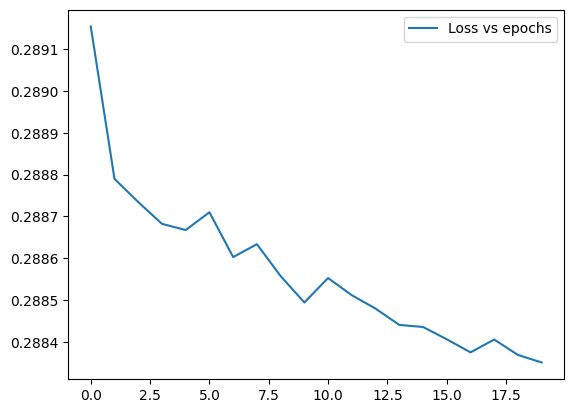

In [11]:
##print(len(history.history['loss']))
fhst=plt.figure()
ax=fhst.add_subplot()
ax.plot(history.history['loss'][0:], label='Loss vs epochs')
ax.legend()
plt.show()

In [13]:
model.save_weights(wdir+'aFitCVXdeg4_12_C_9D4_Weights', overwrite=True, save_format='tf', options=None)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 42,201
Trainable params: 42,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
pTest=np.zeros((1,8))
print(model(pTest))
pTest=np.array([ -2, 3, -2, 1, 6, -6, 6, 9],dtype=np.float32)
pTest=(pTest-cntp)/dxMax
print(model(pTest.reshape(1,8)))

tf.Tensor([[1.6471316e-14]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.5560561e-14]], shape=(1, 1), dtype=float32)


0    (8, 200)
1    (200,)
2    (200, 200)
3    (200,)
4    (200, 1)
5    (1,)
Layer 2: number of weights >0.001 = 4567
Layer 4: number of weights >0.001 = 55
Bias of last layer =  -3.0856924057006836


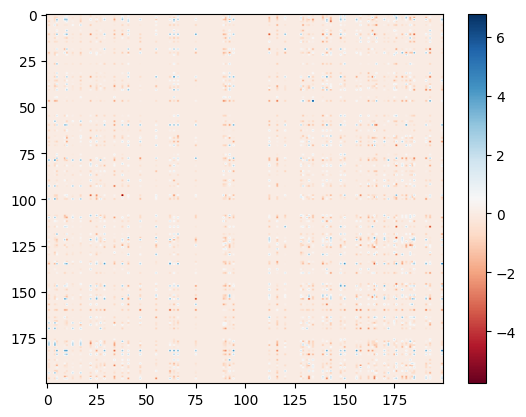

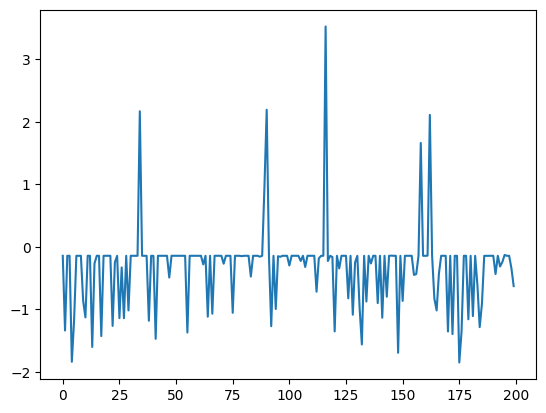

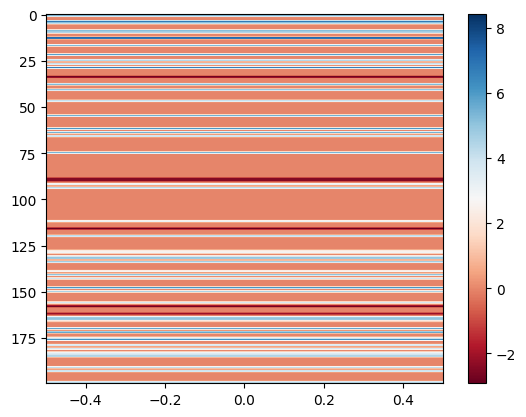

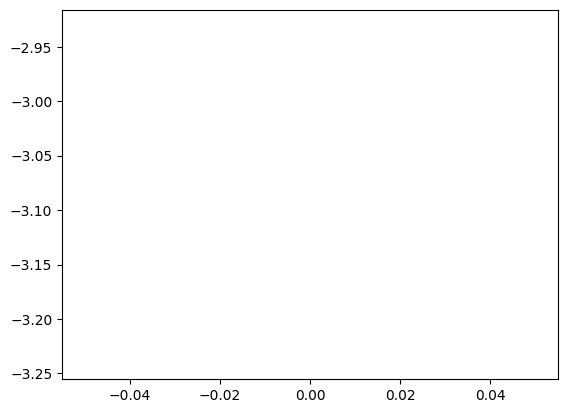

In [15]:
vw=model.get_weights()
k=0
for w in vw:
    print(k,'  ', w.shape);k+=1

if(0):
    w=vw[2]
    fg,ax=plt.subplots(nrows=1,ncols=3,figsize=(10,5))
    #fg.tight_layout()
    fg.subplots_adjust(wspace=1)
    #fg=plt.figure()
    #ax1=fg.add_subplot(1,3,1)
    cmap1=ax[0].imshow(w, cmap=plt.cm.RdBu)
    fg.colorbar(cmap1)
    w=vw[4]
    #ax2=fg.add_subplot(1,3,2)
    cmap2=ax[1].imshow(w, cmap=plt.cm.RdBu)
    fg.colorbar(cmap2)
    w=vw[6]
    #ax3=fg.add_subplot(1,3,3)
    cmap3=ax[2].imshow(w, cmap=plt.cm.RdBu)
    fg.colorbar(cmap3)
if(1):
    eps=1.0e-3
    kk=2
    w=vw[kk]
    fg1=plt.figure()
    ax1=fg1.add_subplot()
    cmap1=ax1.imshow(w, cmap=plt.cm.RdBu,aspect='auto')  #;ax1.set_aspect('equal')
    fg1.colorbar(cmap1)
    fg11=plt.figure()
    ax11=fg11.add_subplot()
    ax11.plot(range(vw[kk+1].shape[0]),vw[kk+1])
    print('Layer {}: number of weights >{} = {}'.format(kk,eps,np.sum(np.abs(w)>eps)))
    kk=4
    w=vw[kk]
    fg2=plt.figure()
    ax1=fg2.add_subplot()
    cmap1=ax1.imshow(w, cmap=plt.cm.RdBu,aspect='auto')
    fg2.colorbar(cmap1)
    fg21=plt.figure()
    ax11=fg21.add_subplot()
    ax11.plot(range(vw[kk+1].shape[0]),vw[kk+1])
    print('Layer {}: number of weights >{} = {}'.format(kk,eps,np.sum(np.abs(w)>eps)))
    if(len(vw)>6):
        kk=6
        w=vw[kk]
        fg3=plt.figure()
        ax1=fg3.add_subplot()
        cmap1=ax1.imshow(w, cmap=plt.cm.RdBu,aspect='auto')
        fg3.colorbar(cmap1)
        print('Layer {}: number of weights >{} = {}'.format(kk,eps,np.sum(np.abs(w)>eps)))
    print('Bias of last layer =  {}'.format(vw[-1][0]))
plt.show()

In [16]:
%%shell
jupyter nbconvert --to html  drive/MyDrive/ColabNtbs/ysNN_PolyN/batch_104_fit/aFitCVXdeg4_12_C_9D4.ipynb

[NbConvertApp] Converting notebook drive/MyDrive/ColabNtbs/ysNN_PolyN/batch_104_fit/aFitCVXdeg4_12_C_9D4.ipynb to html
[NbConvertApp] Writing 923574 bytes to drive/MyDrive/ColabNtbs/ysNN_PolyN/batch_104_fit/aFitCVXdeg4_12_C_9D4.html
